In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
import subprocess
import os
%matplotlib inline

In [5]:
fnames = sorted(glob.glob('/home/vagrant/shared/data/nsamicrobase2shupeturnC1/nsamicrobase2shupeturnC1.c1.20160615*.cdf'))


In [14]:
# run only every 300th time step. 
step = 300

In [6]:
fnames

['/home/vagrant/shared/data/nsamicrobase2shupeturnC1/nsamicrobase2shupeturnC1.c1.20160615.001000.cdf']

In [7]:
template = {}

In [8]:
# see libradtran manual for details
template['sw'] = '''

output sum
output_user edir eup edn sza

atmosphere_file  /usr/local/share/libRadtran/data/atmmod/afglsw.dat
radiosonde %radiosonde% H2O RH

data_files_path /usr/local/share/libRadtran/data

wc_file %wc_file% 
ic_file %ic_file% 
ic_properties fu

aerosol_default

correlated_k fu           # Integrated solar radiation using Kato et al.
wavelength_index 1 6

latitude 70 29.7
longitude -149 53.16
time %YYYY% %MM% %DD% %hh% %mm% %ss%

source solar

albedo %albedo%

quiet
'''

In [9]:
template['lw'] = '''

output sum
output_user edir eup edn sza

atmosphere_file  /usr/local/share/libRadtran/data/atmmod/afglsw.dat
radiosonde %radiosonde% H2O RH

data_files_path /usr/local/share/libRadtran/data

wc_file %wc_file% 
ic_file %ic_file% 
ic_properties fu

aerosol_default

correlated_k fu           # Integrated solar radiation using Kato et al.
wavelength_index 7 18

latitude 70 29.7
longitude -149 53.16
time %YYYY% %MM% %DD% %hh% %mm% %ss%

source thermal

albedo %albedo%

quiet
'''

In [10]:
def runUvspec(INP):

    proc = subprocess.Popen(
        '/usr/local/bin/uvspec',
        shell=True,
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )
    msg = INP.encode('utf-8')
    stdout_value, stderr_value = proc.communicate(msg)
    result  = stdout_value.decode('utf-8')
    
    if len(stderr_value) > 0:
        print('stderr      :', repr(stderr_value.decode('utf-8')))
        
    return np.array([x for x in result.strip().split(' ') if len(x) >0]).astype(float)

In [11]:

albedo={
    'sw' : 0.9,
    'lw' : 0,
}

In [15]:
results = []

for fname in fnames:


    dat = xr.open_dataset(fname)
    dat['time'] = dat.time_offset

    dat = dat.isel(time=range(0,len(dat.time),step))

    result = xr.Dataset(coords={'time':dat['time'] , 'wavelength':['lw','sw']})
    for key in ['edir', 'eup', 'edn', 'sza']:
        result[key] = xr.DataArray(np.zeros((len(dat['time']),2))*np.nan,dims=['time','wavelength'])

    results.append(result)

    date = fname.split('.')[-3]
    sonde = xr.open_mfdataset('/home/vagrant/shared/data/nsainterpolatedsondeC1/nsainterpolatedsondeC1.c1.%s*'%date)
    sonde = sonde[['temp','rh','bar_pres']].reindex(time=dat.time,method='nearest',tolerance=np.timedelta64(1,'m'))
    sonde = sonde.rename({'height':'sonde_height'}).load()

    timeIndices = range(len(dat['time']))

    for tt in timeIndices:

        print (fname, tt, dat.time.values[tt])

        datPd = dat.isel(time=tt,instrum=0,nheights = dat.nheights.values[::-1]).to_dataframe()
        datPd.Heights = datPd.Heights/1000.
        datPd.Avg_Retrieved_IWC = datPd.Avg_Retrieved_IWC/1000.

        sondePd = sonde.isel(time=tt,sonde_height = range(len(sonde.sonde_height))[::-1]).to_dataframe()
        sondePd.temp = sondePd.temp + 273.15
        sondePd.bar_pres = sondePd.bar_pres * 10

        sondePd = sondePd.dropna(how='any')
        wcFile = '%s.%i.lwc.dat'%('.'.join(fname.split('/')[-1].split('.')[:-1]),tt)
        datPd.to_csv(wcFile,
                     sep=' ',
                     columns=['Heights','Avg_Retrieved_LWC','Avg_LiqEffectiveRadius'],
                     index=False,
                     header=False
                    )
        icFile = '%s.%i.iwc.dat'%('.'.join(fname.split('/')[-1].split('.')[:-1]),tt)
        datPd.to_csv(icFile,
                     sep=' ',
                     columns=['Heights','Avg_Retrieved_IWC','Avg_IceEffectiveRadius'],
                     index=False,
                     header=False
                    )
        sondeFile = '%s.%i.sonde.dat'%('.'.join(fname.split('/')[-1].split('.')[:-1]),tt)
        sondePd.to_csv(sondeFile,
                     sep=' ',
                     columns=['bar_pres','temp','rh'],
                     index=False,
                     header=False
                    )


        for ww, wl in enumerate(['sw','lw']):



            thisTemplate=deepcopy(template[wl])

            thisTemplate = thisTemplate.replace('%wc_file%',wcFile )
            thisTemplate = thisTemplate.replace('%ic_file%',icFile )
            thisTemplate = thisTemplate.replace('%radiosonde%',sondeFile )
            thisTemplate = thisTemplate.replace('%YYYY%',str(datPd.time_offset[0].year) )
            thisTemplate = thisTemplate.replace('%MM%',str(datPd.time_offset[0].month).zfill(2) )
            thisTemplate = thisTemplate.replace('%DD%',str(datPd.time_offset[0].day).zfill(2) )
            thisTemplate = thisTemplate.replace('%hh%',str(datPd.time_offset[0].hour).zfill(2) )
            thisTemplate = thisTemplate.replace('%mm%',str(datPd.time_offset[0].minute).zfill(2) )
            thisTemplate = thisTemplate.replace('%ss%',str(datPd.time_offset[0].second).zfill(2) )
            thisTemplate = thisTemplate.replace('%albedo%',str(albedo[wl]))

            edir, eup, edn, sza = runUvspec(thisTemplate)

            result['edir'][tt,ww] = edir
            result['eup'][tt,ww] = eup
            result['edn'][tt,ww] = edn
            result['sza'][tt,ww] = sza

        os.remove(sondeFile)
        os.remove(icFile)
        os.remove(wcFile)



/home/vagrant/shared/data/nsamicrobase2shupeturnC1/nsamicrobase2shupeturnC1.c1.20160615.001000.cdf 0 2016-06-15T00:10:00.000000000


/home/vagrant/miniconda/lib/python3.6/site-packages/xarray/coding/variables.py:135: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


/home/vagrant/shared/data/nsamicrobase2shupeturnC1/nsamicrobase2shupeturnC1.c1.20160615.001000.cdf 1 2016-06-15T05:10:00.000000000
/home/vagrant/shared/data/nsamicrobase2shupeturnC1/nsamicrobase2shupeturnC1.c1.20160615.001000.cdf 2 2016-06-15T10:10:00.000000000
/home/vagrant/shared/data/nsamicrobase2shupeturnC1/nsamicrobase2shupeturnC1.c1.20160615.001000.cdf 3 2016-06-15T15:10:00.000000000
/home/vagrant/shared/data/nsamicrobase2shupeturnC1/nsamicrobase2shupeturnC1.c1.20160615.001000.cdf 4 2016-06-15T20:10:00.000000000


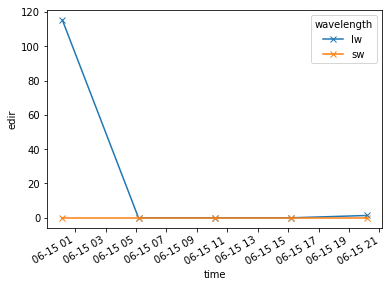

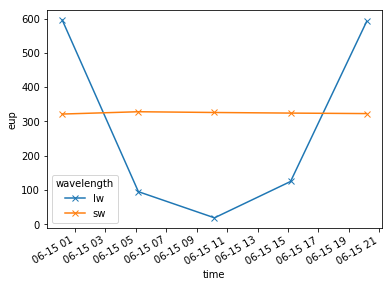

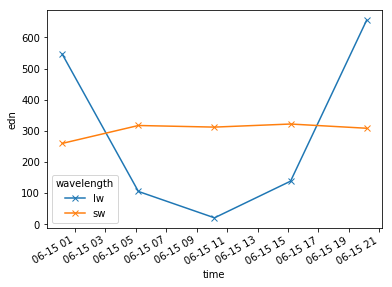

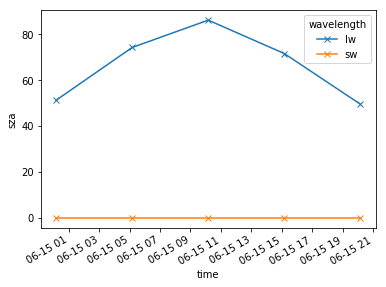

In [16]:
for result in results:
    for k in ['edir', 'eup', 'edn', 'sza']:
        plt.figure()
        result[k].plot.line(x='time', marker='x')
#         plt.savefig('%s.png'%k)

In [ ]:
# xr.concat(results,dim='time').to_netcdf('results_libradtran.nc')